In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import os
import umap
import matplotlib.pyplot as plt
import random as rnd
import itertools
import time

In [2]:
import distances
import linalg_tools as lt
import network_tools as nt

In [3]:
features = pd.read_csv('/Volumes/lucia_ext/bioprofiling/joel_data/features.csv')
labels = pd.read_csv('/Volumes/lucia_ext/bioprofiling/joel_data/labels.csv')

In [4]:
features.head()

,Unnamed: 0,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,DMSO_0,0.536562,12.487356,15.778500,24.338522,26.368895,24.041025,4.869900,4.391946,4.476412,...,8.317855,6.776128,6.255066,6.379255,6.257462,5.917157,5.897430,8.561354,9.569790,9.453573
1,DMSO_1,0.926005,13.042775,15.864564,25.510711,27.358829,23.517355,3.327665,5.950912,6.129566,...,6.649360,6.764805,5.908750,6.120350,6.509722,6.352012,6.267585,8.960855,9.907962,9.727644
2,DMSO_2,0.547070,13.195994,16.581769,24.039963,26.069198,24.341833,5.070974,4.349347,4.451659,...,7.334971,6.745958,6.098836,6.282019,5.622088,5.527961,5.353636,8.347267,9.519143,9.371809
3,DMSO_3,0.545389,13.521585,14.917854,24.048312,26.129603,24.503020,5.043355,4.287701,4.387205,...,6.980644,6.456373,5.630042,5.871957,6.138280,6.234191,6.042725,8.283984,9.668199,9.441025
4,DMSO_4,0.568507,13.291756,16.266199,24.435251,26.707209,24.846759,4.542844,4.458894,4.544696,...,9.398771,7.195676,6.709619,6.758405,6.580967,6.254454,6.125311,9.664669,10.661920,10.458926


In [5]:
labels.head()

,0,1,CID,MeSH
0,BRD-A00100033-001-04-8,nifurtimox,6842999,NaN
1,BRD-A00100033-001-04-8,nifurtimox,6842999,NaN
2,BRD-A00100033-001-04-8,nifurtimox,6842999,NaN
3,BRD-A00100033-001-04-8,nifurtimox,6842999,NaN
4,BRD-A00100033-001-04-8,nifurtimox,6842999,NaN


Remove NaN's to have less nodes

In [6]:
idx_to_drop = list(labels.loc[pd.isna(labels["MeSH"]), :].index)
features_nonan = features.drop(idx_to_drop, axis=0)
labels_nonan = labels.drop(idx_to_drop, axis=0)

In [7]:
rndstate = np.random.RandomState()
datamap_dl = umap.umap_.fuzzy_simplicial_set(features_nonan.values[:,1:], 15, rndstate, "euclidean")
graph_dl = nx.from_scipy_sparse_matrix(datamap_dl[0], create_using = nx.Graph)

In [8]:
labels_list = [l[3] for l in labels_nonan.values.tolist()]
nodes = list(range(len(graph_dl)))
labels_dict = dict(zip(nodes, labels_list))
nx.set_node_attributes(graph_dl, labels_dict, 'labels')

In [9]:
nx.get_node_attributes(graph_dl, 'labels')[100]

'Membrane Transport Modulators'

In [10]:
unique_labels = list(set(labels_list))
len(unique_labels)

91

### Have a look at network

In [12]:
nx.number_of_nodes(graph_dl)

5807

In [13]:
nx.number_of_edges(graph_dl)

64411

In [14]:
nx.density(graph_dl)

0.003820860482861236

In [15]:
nx.average_clustering(graph_dl)

0.36259575466105715

In [16]:
nt.avg_deg(graph_dl)

22.183915963492336

-3.854654354087995

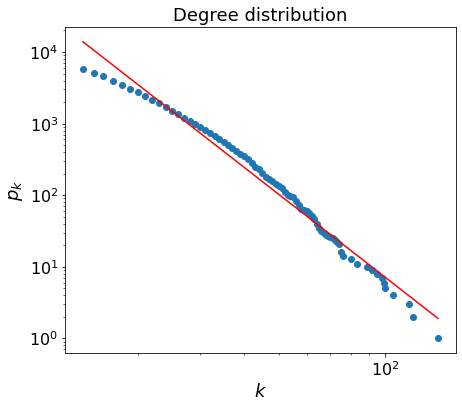

In [17]:
paras = nt.fitting(graph_dl, plot=True, cumulative=True)
paras[0]

-3.6934998424968346

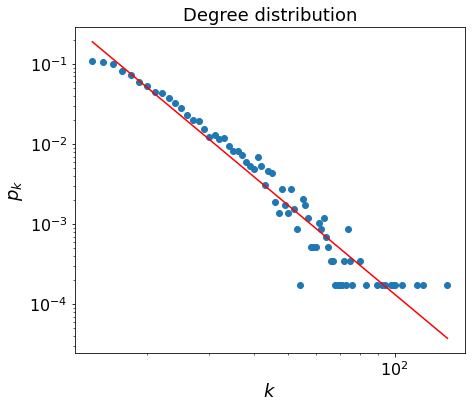

In [20]:
paras = nt.fitting(graph_dl, plot=True, cumulative=False)
paras[0]

In [21]:
max(list(d for n, d in graph_dl.degree()))

141

In [22]:
nx.number_connected_components(graph_dl)

2

Remove the small connected component (since it's very very small)

In [24]:
gcc = sorted(nx.connected_components(graph_dl), key=len, reverse=True)
graph_dl = graph_dl.subgraph(gcc[0])

### Visualize network

In [25]:
pos_spring = nx.spring_layout(graph_dl)
pos_spectr = nx.spectral_layout(graph_dl)
d = dict(graph_dl.degree)

In [26]:
from matplotlib import cm

dict_keys = list(set(labels_list))
viridis = cm.get_cmap('viridis', len(dict_keys))
dict_values = [viridis(n) for n in np.linspace(0, 1, len(dict_keys))]
colors = {dict_keys[i]:dict_values[i] for i in range(len(dict_keys))}

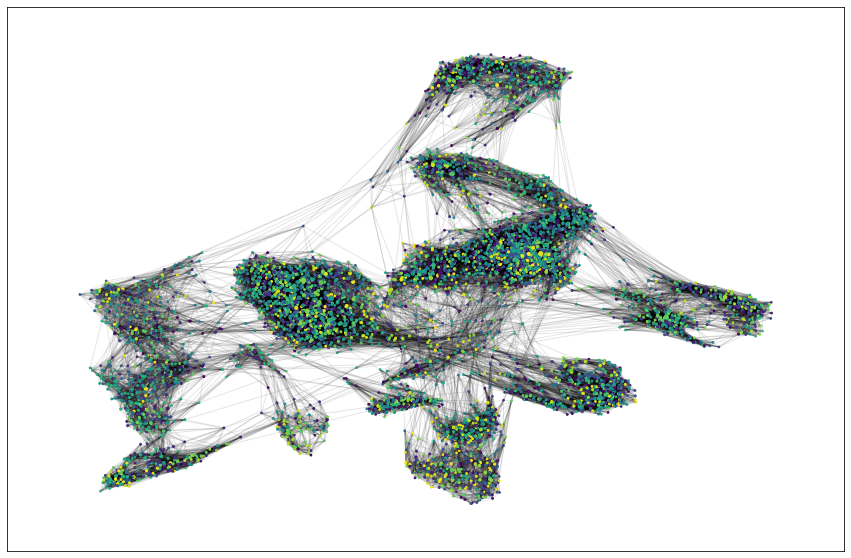

In [27]:
fig = plt.figure(figsize=(15, 10))


nx.draw_networkx_edges(graph_dl, pos=pos_spring, alpha=0.1)
nx.draw_networkx_nodes(graph_dl, pos=pos_spring, node_size=[v/5 for v in d.values()], 
                       node_color=[colors[node[1]['labels']] for node in graph_dl.nodes(data=True)])
plt.show()

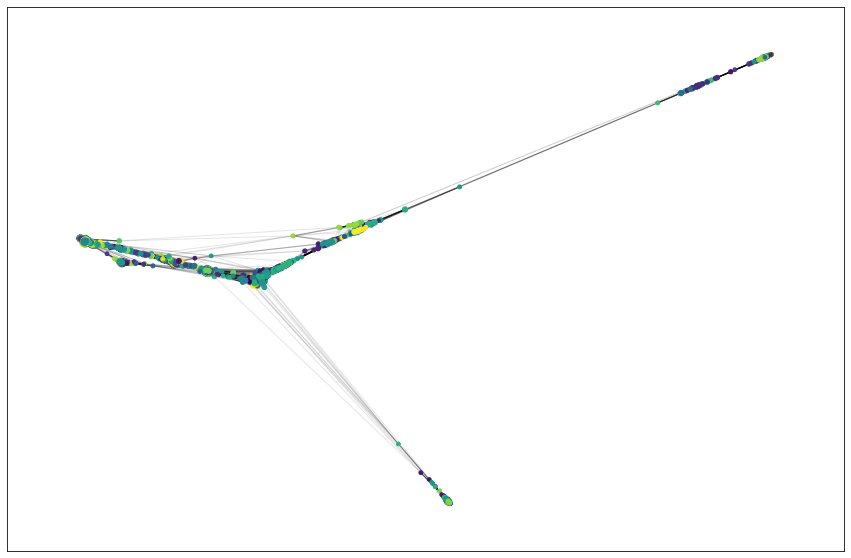

In [28]:
fig = plt.figure(figsize=(15, 10))
nx.draw_networkx_edges(graph_dl, pos=pos_spectr, alpha=0.1)
nx.draw_networkx_nodes(graph_dl, pos=pos_spectr, node_size=[v for v in d.values()], 
                       node_color=[colors[node[1]['labels']] for node in graph_dl.nodes(data=True)])
plt.show()

### Checking that nodes in the same category are closer to each other than nodes in different categories

In [12]:
l = ['Vinca Alkaloids', 'Tubulin Modulators', 'Topoisomerase II Inhibitors']
labels_data = [[node for node in graph_dl.nodes(data=True) if node[1]['labels']==label] for label in l]
labels_nodes = [[node[0] for node in label] for label in labels_data]
subgraphs = [graph_dl.subgraph(label) for label in labels_nodes]

In [13]:
for subgraph in subgraphs:
    print(subgraph.number_of_edges())

13
59
93


In [47]:
labels_data

[[(456, {'labels': 'Vinca Alkaloids'}),
  (457, {'labels': 'Vinca Alkaloids'}),
  (458, {'labels': 'Vinca Alkaloids'}),
  (459, {'labels': 'Vinca Alkaloids'}),
  (460, {'labels': 'Vinca Alkaloids'}),
  (461, {'labels': 'Vinca Alkaloids'}),
  (462, {'labels': 'Vinca Alkaloids'}),
  (463, {'labels': 'Vinca Alkaloids'}),
  (2206, {'labels': 'Vinca Alkaloids'}),
  (2207, {'labels': 'Vinca Alkaloids'}),
  (2208, {'labels': 'Vinca Alkaloids'}),
  (2209, {'labels': 'Vinca Alkaloids'}),
  (2210, {'labels': 'Vinca Alkaloids'}),
  (2211, {'labels': 'Vinca Alkaloids'}),
  (2212, {'labels': 'Vinca Alkaloids'}),
  (2213, {'labels': 'Vinca Alkaloids'}),
  (5419, {'labels': 'Vinca Alkaloids'}),
  (5420, {'labels': 'Vinca Alkaloids'}),
  (5421, {'labels': 'Vinca Alkaloids'}),
  (5422, {'labels': 'Vinca Alkaloids'}),
  (5423, {'labels': 'Vinca Alkaloids'}),
  (5424, {'labels': 'Vinca Alkaloids'}),
  (5425, {'labels': 'Vinca Alkaloids'}),
  (5426, {'labels': 'Vinca Alkaloids'})],
 [(128, {'labels': 'Pro

In [14]:
def fill_lower_diag(a):
    n = int(np.sqrt(len(a)*2))
    mask = np.tri(n,dtype=bool, k=0) 
    out = np.zeros((n,n),dtype=float)
    out[mask] = a
    return out

def init_array(n):
    num = int(n*(n+1)/2)
    arr = [[] for _ in range(num)]
    return arr

In [16]:
theta = 5
large_number = 100
iterations = 5 # I think 20 or so would be better
num_samples = 3 # I think 10 or so would be better

arr = init_array(len(labels_data))

for i in range(iterations):
    start = time.time()
    print(f'starting iteration: {i}')
    
    samples = [rnd.sample(labels_data[i], num_samples) for i in range(len(labels_data))]
    
    arr_pos = 0
    for idx_i in range(len(samples)):
        for idx_j in range(idx_i+1):
            pairwise_dist = [distances.diss_distance(samples[idx_i][idx][0], samples[idx_j][idx1][0], theta, graph_dl, large_number)
                                for idx in range(num_samples) for idx1 in range(idx+1)]
            print(f'indices: {idx_i}, {idx_j}')
            print(f'pairwise distances: {pairwise_dist}')
            med = np.median(pairwise_dist)
            print(f'median of pairwise distances: {med}')
            arr[arr_pos].append(med)
            print(f'array so far: {arr}')
            arr_pos += 1
    
    end = time.time()
    print(f'elapsed time for iteration {i}: {end-start}')

starting iteration: 0
indices: 0, 0
pairwise distances: [3.9008952675160387e-218, 1.0231995175161395, 3.46050241524263e-218, 1.2449804296875813, 1.7219665928366235, 4.2710826554800064e-218]
median of pairwise distances: 0.5115997587580697
array so far: [[0.5115997587580697], [], [], [], [], []]
indices: 1, 0
pairwise distances: [1.8707244780692553, 1.397844195005469, 1.4773993595175408, 1.4139871198186569, 1.5702930406539028, 1.687249297676058]
median of pairwise distances: 1.5238462000857218
array so far: [[0.5115997587580697], [1.5238462000857218], [], [], [], []]
indices: 1, 1
pairwise distances: [4.3816230255589877e-218, 1.7961603359507388, 4.895860600477321e-218, 1.394993571077615, 1.7391137157673415, 3.46191442129929e-218]
median of pairwise distances: 0.6974967855388075
array so far: [[0.5115997587580697], [1.5238462000857218], [0.6974967855388075], [], [], []]
indices: 2, 0
pairwise distances: [1.7212824484004878, 1.5100993063182733, 0.7151940863010858, 1.2408130457867013, 0.44

indices: 1, 0
pairwise distances: [1.7892406384140473, 2.296259327591848, 1.4988916843934486, 1.751715299567124, 1.9168152883746226, 1.9604892812830856]
median of pairwise distances: 1.853027963394335
array so far: [[0.5115997587580697, 0.3274801273640934, 0.10509906347209756, 0.04714992715339605], [1.5238462000857218, 1.9454378534869994, 1.5763278547343162, 1.853027963394335], [0.6974967855388075, 0.28591807330398733, 0.3660661130710099], [1.3754561760524873, 1.7804407740888966, 1.541855563187951], [1.8839943787893758, 1.1886213938418915, 1.5092207560112592], [0.16876340918887361, 0.25578671769964556, 0.6505883234917405]]
indices: 1, 1
pairwise distances: [4.979649154870514e-218, 1.2615346980547115, 4.3501359053057764e-218, 1.2914051322319253, 1.079787672940806, 5.530088754440432e-218]
median of pairwise distances: 0.539893836470403
array so far: [[0.5115997587580697, 0.3274801273640934, 0.10509906347209756, 0.04714992715339605], [1.5238462000857218, 1.9454378534869994, 1.576327854734

In [17]:
arr

[[0.5115997587580697,
  0.3274801273640934,
  0.10509906347209756,
  0.04714992715339605,
  0.3521791336146288],
 [1.5238462000857218,
  1.9454378534869994,
  1.5763278547343162,
  1.853027963394335,
  1.4960682768378473],
 [0.6974967855388075,
  0.28591807330398733,
  0.3660661130710099,
  0.539893836470403,
  0.5880436432910295],
 [1.3754561760524873,
  1.7804407740888966,
  1.541855563187951,
  1.746631600397372,
  2.114935587554725],
 [1.8839943787893758,
  1.1886213938418915,
  1.5092207560112592,
  1.1342997145209042,
  2.2230293185671908],
 [0.16876340918887361,
  0.25578671769964556,
  0.6505883234917405,
  0.36164452006144376,
  0.7620410086284903]]

In [18]:
arr_medians = [np.median(arr[i]) for i in range(len(arr))]
arr_medians

[0.3274801273640934,
 1.5763278547343162,
 0.539893836470403,
 1.746631600397372,
 1.5092207560112592,
 0.36164452006144376]

In [19]:
final_arr = fill_lower_diag(arr_medians)
final_arr = final_arr+np.transpose(final_arr)-np.diag(final_arr)
final_arr

array([[0.32748013, 1.03643402, 1.38498708],
       [1.24884773, 0.53989384, 1.14757624],
       [1.41915147, 0.96932692, 0.36164452]])

In [20]:
df = pd.DataFrame(final_arr, columns=l, index=l)
df

,Vinca Alkaloids,Tubulin Modulators,Topoisomerase II Inhibitors
Vinca Alkaloids,0.327480,1.036434,1.384987
Tubulin Modulators,1.248848,0.539894,1.147576
Topoisomerase II Inhibitors,1.419151,0.969327,0.361645
